In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import sys
sys.path.append("../..")
from modules.autoencoders import *
from modules.modelwithtrainer import *

In [2]:
# Loading data
inputFeature = pd.read_csv('../../../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
# Separating numerical and categorical features
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']
# Onehot-encoding categorical features
inputFeature_1h = pd.get_dummies(inputFeature, columns=categorical_features)

In [3]:
categorymapper = {
    "all_columns" : categorical_features,
    "all_indices" : [],
    "columns": {},
    "values": {}
}

for column in inputFeature_1h.columns:
    splitted_colname = column.split(" ")
    double_splitted_colname = splitted_colname[0].split("_")
    original_colname = "_".join(double_splitted_colname[:-1])
    if original_colname in categorical_features:
        first_value = double_splitted_colname[-1:]
        column_value = " ".join(first_value + splitted_colname[1:])
        column_index = inputFeature_1h.columns.get_loc(column)
        categorymapper["all_indices"].append(column_index)
        categorymapper["columns"].update({column_index:original_colname})
        categorymapper["values"].update({column_index:column_value})

In [4]:
# Convert object columns to numeric if they represent categories
for column in inputFeature_1h.select_dtypes(include=['object']):
    inputFeature_1h[column] = inputFeature_1h[column].astype('category').cat.codes

# Train-test split
train, test = train_test_split(inputFeature_1h, test_size=0.1, random_state=42)

# Scaling features
scaler = MinMaxScaler().fit(train[numerical_features])
train[numerical_features] = scaler.transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

# Converting data to tensors
X_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))
y_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))

X_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))
y_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))

In [5]:
# Dataloaders
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [6]:
# Define sizes for the layers
layer_sizes = [229, 64, 32]  # Example decreasing sizes for the encoder

# Create the encoder ModuleList
encoder = nn.ModuleList()
for i in range(len(layer_sizes) - 1):
    encoder.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
    encoder.append(nn.ReLU())

# Create the decoder ModuleList (mirror of the encoder)
decoder = nn.ModuleList()
decoder.append(nn.Linear(1, layer_sizes[len(layer_sizes) - 1]))
for i in range(len(layer_sizes) - 1, 0, -1):
    decoder.append(nn.Linear(layer_sizes[i], layer_sizes[i - 1]))
    decoder.append(nn.ReLU())

# Remove the last ReLU from the decoder (optional, depending on use case)
decoder = decoder[:-1]
criterion = PCAAE_Loss(nn.MSELoss())
model = PCAAutoencoder(encoder, decoder, 32)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
print_every = 40
callbacks = [ModelCheckPoint(monitored_metric="val reconstruction loss epoch",
                             minimize_metric=True),
            EarlyStopping(monitored_metric="val reconstruction loss epoch",
                          minimize_metric=True,
                          patience=10)]

In [7]:
logs = model.fit(optimizer, criterion, epochs, trainloader, testloader, goal_hidden_dim=5, callbacks=callbacks, save_filename="pcaautoencoder",
                 embed_hidden=True, categorymapper=categorymapper)

TensorBoard started at http://localhost:6006
Training with hidden dim: 1
step 40 - train loss: 0.0463, train reconstruction loss: 0.0463, train covariance loss: 0.0000
step 80 - train loss: 0.0261, train reconstruction loss: 0.0261, train covariance loss: 0.0000
step 120 - train loss: 0.0252, train reconstruction loss: 0.0252, train covariance loss: 0.0000
step 160 - train loss: 0.0244, train reconstruction loss: 0.0244, train covariance loss: 0.0000
step 200 - train loss: 0.0243, train reconstruction loss: 0.0243, train covariance loss: 0.0000
step 240 - train loss: 0.0243, train reconstruction loss: 0.0243, train covariance loss: 0.0000
step 280 - train loss: 0.0241, train reconstruction loss: 0.0241, train covariance loss: 0.0000
step 320 - train loss: 0.0237, train reconstruction loss: 0.0237, train covariance loss: 0.0000
step 360 - train loss: 0.0238, train reconstruction loss: 0.0238, train covariance loss: 0.0000
step 400 - train loss: 0.0235, train reconstruction loss: 0.0235,

c:\Users\CSANADANSYS\Desktop\NN projekt\crime analysis\new\notebooks\test_modules\../..\modules\modelwithtrainer\callbacks.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Training with hidden dim: 2
step 40 - train loss: 0.0480, train reconstruction loss: 0.0295, train covariance loss: 1.8508
step 80 - train loss: 0.0422, train reconstruction loss: 0.0237, train covariance loss: 1.8471
step 120 - train loss: 0.0414, train reconstruction loss: 0.0229, train covariance loss: 1.8474
step 160 - train loss: 0.0412, train reconstruction loss: 0.0226, train covariance loss: 1.8584
step 200 - train loss: 0.0412, train reconstruction loss: 0.0226, train covariance loss: 1.8557
step 240 - train loss: 0.0409, train reconstruction loss: 0.0224, train covariance loss: 1.8505
step 280 - train loss: 0.0414, train reconstruction loss: 0.0229, train covariance loss: 1.8548
step 320 - train loss: 0.0405, train reconstruction loss: 0.0221, train covariance loss: 1.8491
step 360 - train loss: 0.0407, train reconstruction loss: 0.0221, train covariance loss: 1.8538
step 400 - train loss: 0.0405, train reconstruction loss: 0.0219, train covariance loss: 1.8611
step 440 - tra

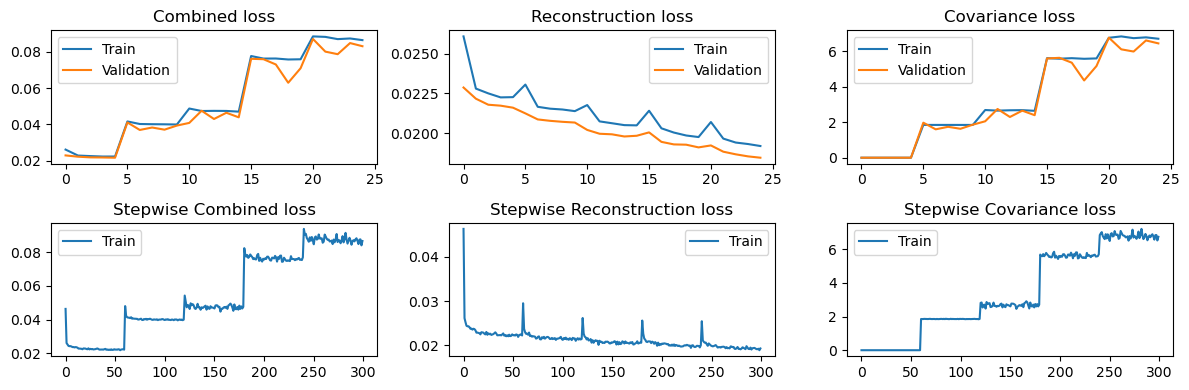

In [8]:
f, ax = plt.subplots(2, 3, figsize=(12, 4))
ax[0, 0].plot(logs["train loss epoch"], label="Train")
ax[0, 0].plot(logs["val loss epoch"], label="Validation")
ax[0, 0].set_title("Combined loss")
ax[0, 0].legend()
ax[0, 1].plot(logs["train reconstruction loss epoch"], label="Train")
ax[0, 1].plot(logs["val reconstruction loss epoch"], label="Validation")
ax[0, 1].set_title("Reconstruction loss")
ax[0, 1].legend()
ax[0, 2].plot(logs["train covariance loss epoch"], label="Train")
ax[0, 2].plot(logs["val covariance loss epoch"], label="Validation")
ax[0, 2].set_title("Covariance loss")
ax[0, 2].legend()
ax[1, 0].plot(logs["train loss step"], label="Train")
ax[1, 0].set_title("Stepwise Combined loss")
ax[1, 0].legend()
ax[1, 1].plot(logs["train reconstruction loss step"], label="Train")
ax[1, 1].set_title("Stepwise Reconstruction loss")
ax[1, 1].legend()
ax[1, 2].plot(logs["train covariance loss step"], label="Train")
ax[1, 2].set_title("Stepwise Covariance loss")
ax[1, 2].legend()

plt.tight_layout()
plt.show()